In [32]:
import pandas as pd
import os.path as osp
import numpy as np
from tqdm import tqdm
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv
#from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch.nn.functional as F
import pandas as pd
import seaborn as sns

In [ ]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

In [2]:
node_feat = np.load("paper_emb.npy")
node_feat.shape

(168319, 384)

In [3]:
edge = np.load("paper_edges.npy")
edge.shape

(2, 395888)

In [5]:
num_node_list = np.array([168319])
num_edge_list = np.array([395888])

In [6]:
edge_feat = None

In [7]:
node_feat.dtype

dtype('float32')

In [8]:
graph_list = []
num_node_accum = 0
num_edge_accum = 0
for num_node, num_edge in tqdm(zip(num_node_list, num_edge_list), total=len(num_node_list)):
    graph = dict()
    duplicated_edge = np.repeat(edge[:, num_edge_accum:num_edge_accum+num_edge], 2, axis = 1)
    duplicated_edge[0, 1::2] = duplicated_edge[1,0::2]
    duplicated_edge[1, 1::2] = duplicated_edge[0,0::2]
    graph['edge_index'] = duplicated_edge
    graph['edge_feat'] = None
    
    num_edge_accum += num_edge
    
    graph['node_feat'] = node_feat[num_node_accum:num_node_accum+num_node]
    
    graph['num_nodes'] = num_node
    num_node_accum += num_node
    graph_list.append(graph)

100%|██████████| 1/1 [00:00<00:00, 113.62it/s]


In [10]:
pyg_graph_list = []
for graph in tqdm(graph_list):
    g = Data()
    g.num_nodes = graph['num_nodes']
    g.edge_index = torch.from_numpy(graph['edge_index'])
    g.x = torch.from_numpy(graph['node_feat'])
    pyg_graph_list.append(g)

100%|██████████| 1/1 [00:00<00:00, 4350.94it/s]


In [11]:
pyg_graph_list

[Data(num_nodes=168319, edge_index=[2, 791776], x=[168319, 384])]

In [12]:
data = pyg_graph_list[0]

In [13]:
node_label = np.load("paper_label.npy")

In [14]:
data.y = torch.from_numpy(node_label).to(torch.long)

In [15]:
node_label

array([ 1, 17,  7, ...,  3, 13,  3])

In [18]:
data.to(device)

Data(num_nodes=168319, edge_index=[2, 791776], x=[168319, 384], y=[168319])

In [19]:
data = T.ToSparseTensor()(data)

In [20]:
data.adj_t = data.adj_t.to_symmetric()

In [36]:
data

Data(num_nodes=168319, x=[168319, 384], y=[168319], adj_t=[168319, 168319, nnz=395854])

In [21]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)

In [22]:
log_steps=5
num_layers=3
hidden_channels=256
dropout=0.5
lr=0.05
epochs=600
runs=1

TRAIN = 6000
VAL = 1232
TEST = 1000
train_idx = [i for i in range(6000)]
val_idx = [i for i in range(6000, 7232)]
test_idx = [i for i in range(7232, 8232)]

In [23]:
model = SAGE(384, hidden_channels,
                     19, num_layers,
                     dropout).to(device)

In [24]:
def train(model, data, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(data.x, data.adj_t)[train_idx]
    #print(out.shape)
    #print(data.y[train_idx].shape)
    loss = F.nll_loss(out, data.y[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()

def eval_acc(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        if y_true[i] == y_pred[i]:
            acc_list.append(1)
        else:
            acc_list.append(0)
            

    return {'acc': sum(acc_list)/len(acc_list)}

@torch.no_grad()
def test(model, data):
    model.eval()

    out = model(data.x, data.adj_t)
    y_pred = out.argmax(dim=-1, keepdim=True)
    
    train_acc = eval_acc(data.y[train_idx],y_pred[train_idx])['acc']
    val_acc = eval_acc(data.y[val_idx],y_pred[val_idx])['acc']
    test_acc = eval_acc(data.y[test_idx],y_pred[test_idx])['acc']
    #print(train_acc, val_acc, test_acc)
    return train_acc, val_acc, test_acc

In [25]:
import matplotlib.pyplot as plt

In [26]:
train_lst, val_lst, test_lst = [], [], []

In [27]:
for run in range(runs):
    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        loss = train(model, data, optimizer)
        result = test(model, data)
        #print("Loss: ", loss)
        #print("Result: ", result)

        if epoch % log_steps == 0:
            train_acc, valid_acc, test_acc = result
            train_lst.append(train_acc)
            val_lst.append(valid_acc)
            test_lst.append(test_acc)
            print(f'Run: {run + 1:02d}, '
                  f'Epoch: {epoch:02d}, '
                  f'Loss: {loss:.4f}, '
                  f'Train: {100 * train_acc:.2f}%, '
                  f'Valid: {100 * valid_acc:.2f}% '
                  f'Test: {100 * test_acc:.2f}%')

Run: 01, Epoch: 00, Loss: 3.1664, Train: 41.97%, Valid: 42.78% Test: 41.60%
Run: 01, Epoch: 05, Loss: 2.6100, Train: 41.80%, Valid: 42.53% Test: 40.90%
Run: 01, Epoch: 10, Loss: 2.0531, Train: 41.95%, Valid: 40.75% Test: 40.50%
Run: 01, Epoch: 15, Loss: 1.6310, Train: 51.43%, Valid: 51.70% Test: 49.90%
Run: 01, Epoch: 20, Loss: 1.4878, Train: 53.97%, Valid: 52.52% Test: 51.90%
Run: 01, Epoch: 25, Loss: 1.3467, Train: 57.45%, Valid: 56.41% Test: 57.30%
Run: 01, Epoch: 30, Loss: 1.2895, Train: 60.90%, Valid: 58.93% Test: 60.60%
Run: 01, Epoch: 35, Loss: 1.2297, Train: 61.83%, Valid: 59.01% Test: 59.60%
Run: 01, Epoch: 40, Loss: 1.1918, Train: 63.47%, Valid: 59.90% Test: 64.50%
Run: 01, Epoch: 45, Loss: 1.1451, Train: 64.23%, Valid: 61.20% Test: 64.30%
Run: 01, Epoch: 50, Loss: 1.1167, Train: 65.02%, Valid: 61.53% Test: 63.50%
Run: 01, Epoch: 55, Loss: 1.0804, Train: 65.90%, Valid: 62.58% Test: 66.20%
Run: 01, Epoch: 60, Loss: 1.0669, Train: 66.33%, Valid: 63.56% Test: 66.10%
Run: 01, Epo

Run: 01, Epoch: 535, Loss: 0.0307, Train: 100.00%, Valid: 62.42% Test: 65.60%
Run: 01, Epoch: 540, Loss: 0.0300, Train: 100.00%, Valid: 62.58% Test: 65.20%
Run: 01, Epoch: 545, Loss: 0.0311, Train: 100.00%, Valid: 62.66% Test: 65.60%
Run: 01, Epoch: 550, Loss: 0.0271, Train: 100.00%, Valid: 62.74% Test: 66.10%
Run: 01, Epoch: 555, Loss: 0.0225, Train: 99.98%, Valid: 62.66% Test: 65.80%
Run: 01, Epoch: 560, Loss: 0.0272, Train: 100.00%, Valid: 62.26% Test: 65.40%
Run: 01, Epoch: 565, Loss: 0.0305, Train: 100.00%, Valid: 63.39% Test: 67.20%
Run: 01, Epoch: 570, Loss: 0.0275, Train: 100.00%, Valid: 62.99% Test: 65.90%
Run: 01, Epoch: 575, Loss: 0.0310, Train: 100.00%, Valid: 62.50% Test: 66.70%
Run: 01, Epoch: 580, Loss: 0.0283, Train: 100.00%, Valid: 63.15% Test: 66.00%
Run: 01, Epoch: 585, Loss: 0.0276, Train: 100.00%, Valid: 63.23% Test: 66.20%
Run: 01, Epoch: 590, Loss: 0.0290, Train: 100.00%, Valid: 63.56% Test: 66.50%
Run: 01, Epoch: 595, Loss: 0.0285, Train: 100.00%, Valid: 63.23% 

In [33]:
graphSAGE = pd.DataFrame({'train_acc' : train_lst, 'val_acc' : val_lst, 'test_acc' : test_lst})

In [34]:
#graphSAGE['index'] = [i for i in range(len(train_lst))]

Text(0, 0.5, 'Accuracy')

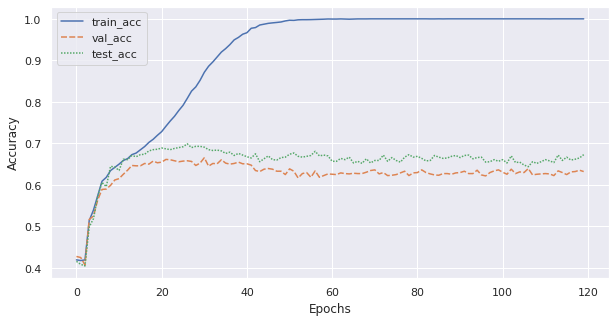

In [35]:
sns.set(style="darkgrid", rc = {'figure.figsize':(10,5)})
ax = sns.lineplot(data=graphSAGE)
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")